# TP2 : Reconstruction tomographique
### Physique Numérique (PHY-3500)
### Par: Simon Gauthier, Laurent Émond, Thomas Charland
### Présenté à: Xavier Roy-Pomerleau
### Remis le: 23 mars 2025

## Mise en contexte

L'arrivée de l'ordinateur a révolutionné la médecine moderne en permettant d'utiliser des méthodes d'imagerie nécessitant sur une puissance de calcul élevée. La tomodensitométrie (TDM), qui permet d'estimer la distribution de la densité d'un objet à partir de plusieurs mesures d'atténuation [1], est l'une de ces méthodes. La tomodensitométrie est majoritairement utilisée pour l'analyse de zones non-visibles par d'autres examens d'imagerie médicale [2], et permet d'obtenir des résultat de l'ordre du millimètre [1]

Ce notebook résout le TP2 du cours de Physique Numérique (PHY-3500). 

In [1]:
#Importer toutes les libraries nécessaires pour la résolution du TP
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import recon as recon
from PIL import Image
import math

# Numéro 1

En utilisant la base de donnée XCOM du NIST [3], nous obtenons un coefficient d'atténuation $\mu = 2.059 \cdot 10^{-1}$ cm^2/g pour un photon de 60KeV voyageant dans l'eau à 1.0 g/cm^3. Afin d'identifier, la fraction du signal qui subsistera au parcours indiqué, nous utiliserons la loi de Beer-Lambert :
$
\begin{align}
ln\left( \frac{I_0}{I} \right) &= \sum \mu(x) \delta x\\
\frac{I_0}{I} &= e^{\left( \sum \mu(x) \delta x \right)}
\end{align}
$

In [2]:
#Code pour résoudre le numéro 1
def remaining_intensity(attenuation_coefs_of_media : list, distance_travelled_in_media : list):
    sum_value = 0
    for i in range(len(attenuation_coefs_of_media)):
        sum_value += attenuation_coefs_of_media[i] * distance_travelled_in_media[i]
    
    remaining_intensity = 100 * math.e**(-sum_value)
    return remaining_intensity / 100

print(f"La fraction du signal subsistant après 5cm est: {remaining_intensity([0.2059], [5]):.5f}")
print(f"La fraction du signal subsistant après 20cm est: {remaining_intensity([0.2059], [20]):.5f}")

La fraction du signal subsistant après 5cm est: 0.35719
La fraction du signal subsistant après 20cm est: 0.01628


En utilisant l'équation 2, nous avons déterminé qu'après avoir traversé 5 cm d'eau, la fraction du signal restante est de 35,72 %. Après 20 cm d'eau, elle n'est plus que de 1,62 %.

# Numéro 2

Une manière simple (et un peu naïve) de reconstruire une image à partir d'un sinogramme tomodensitométrique est d'identifier les rayons qui passent par chaque voxel et de les sommer afin d'obtenir la valeur du pixel [1]. L'image ainsi obtenue est nommée laminogramme. En utilisant cette méthode, dite *voxel-driven*, nous obtenons les images suivantes pour les sinogrammes *sinogram-password.txt* et *sinogram-patient.txt*.

In [3]:
import geo
import util

# Nous débutons avec un fonction permettant de lire une image et de la transformer en une matrice de valeurs
def readInput(angle_file: str, sinogram_file: str) -> list[int, np.ndarray, np.ndarray]:
    """
    Cette fonction permet de lire les fichiers d'angles et de sinogramme.

    angle_file: le fichier contenant les angles de projection
    sinogram_file: le fichier contenant le sinogramme

    return: nombre de projections, les angles de projection et le sinogramme
    """
    # lire les angles
    [nbprj, angles] = util.readAngles(angle_file)

    # Debug
    #print("nbprj:",nbprj)
    #print("angles min and max (rad):")
    #print("["+str(np.min(angles))+", "+str(np.max(angles))+"]")

    # lire le sinogramme
    [nbprj2, nbpix2, sinogram] = util.readSinogram(sinogram_file)

    if nbprj != nbprj2:
        print("Lecture des fichiers d'angles et de sinogramme conflictuelle!")
        exit(0)

    if geo.nbpix != nbpix2:
        print("Lecture des fichiers d'angles et de sinogramme conflictuelle!")
        exit(0)

    return [nbprj, angles, sinogram]
    
# Nous poursuivons avec une fonction permettant d'imager les données sous forme de laminogram
def laminogram(data_input: list[int, np.ndarray, np.ndarray]) -> None:
    
    [nbprj, angles, sinogram] = data_input
    
    # initialiser une image reconstruite
    image = np.zeros((geo.nbvox, geo.nbvox))

    # "etaler" les projections sur l'image
    # ceci sera fait de façon "voxel-driven"
    # pour chaque voxel, trouver la contribution du signal reçu
    for j in range(geo.nbvox): # colonnes de l'image
        print(f"\rWorking on image column: {str(j+1)}/{str(geo.nbvox)}", end="", flush=True)
        for i in range(geo.nbvox): # lignes de l'image
            for a in range(0, len(angles), 1):
                            
                mid_ray = geo.nbpix/2 # indice du rayon central
                mid_vox = geo.nbvox/2 # indice du voxel central en x et en y
                angle = angles[a]
                proj = sinogram[a]

                # déterminer si le rayon est dirigé vers la gauche ou la droite
                # l'algorithme est fait pour les rayons dirigés vers la gauche
                # on peut corriger à la fin pour les rayons dirigés vers la droite
                ray_dir = "left" if angle < np.pi else "right"

                # angle entre 0 et pi
                angle %= np.pi

                # position en voxels relative au centre de la grille de reconstruction
                current_vox_x = j - mid_vox
                current_vox_y = mid_vox - i

                # paramètre d'une droite passant par le voxel courant et la pente du rayon actuel
                m = np.tan(angle + np.pi/2)
                b = current_vox_y - m * current_vox_x

                # vecteur perpendiculaire à la droite mx+b et allant vers le centre de la grille
                perp_vector = [m*b/(m**2 + 1), -b/(m**2 + 1)]

                # norme et angle du vecteur perpendiculaire
                norm_to_center = np.linalg.norm(perp_vector)
                angle_to_center = np.arctan2(perp_vector[1], perp_vector[0])

                # décalage en pixels (détecteur) à partir du centre du détecteur pour avoir le rayon
                # croisant le voxel courant
                if np.isnan(angle_to_center): # si le courant est au centre de la grille, le vecteur est nul
                    ray_index = mid_ray
                
                else: # on ajuste le décalage en fonction de si le vecteur perpendiculaire
                    # pointe dans la même direction que le l'axe du détecteur ou non
                    # Si les angles sont opposés, le décalage doit être inversé 
                    # (sens contraire de t dans la figure 2 de l'énoncé)

                    n_ray_shift = norm_to_center * geo.voxsize / geo.pixsize # convertis n_voxels à n_pixels/n_rays

                    if int(angle_to_center) == int(angle):
                        factor = 1
                    else:
                        factor = -1
                    
                    if ray_dir == "right": # si le rayon est dirigé vers la droite (angle initial > pi avant le modulo)
                                           # on flip l'image dans les deux axes pour garder le même algorithme
                        i = geo.nbvox - i - 1
                        j = geo.nbvox - j - 1
                    
                    ray_index = int(mid_ray + n_ray_shift * factor)

                image[i, j] += proj[ray_index]

    util.saveImage(image, "laminogram")

Une fois notre code correctement établi, nous pouvons l'utiliser pour générer un laminogramme à partir des données contenues dans le fichier sinogram-password.txt. Ce laminogramme offre une représentation visuelle du mot de passe, comme illustré dans la figure ci-dessous. Une fois le mot de passe identifié à partir de cette image reconstruite, il peut être utilisé pour accéder au fantôme numérique

In [4]:
# Lire les données du fichier d'angles et de password "sinogram-password.txt"
data_input = readInput(geo.dataDir + geo.anglesFile, geo.dataDir + geo.pwSinogramFile)
# Créer le laminogram
laminogram(data_input)

Working on image column: 192/192

<Figure size 640x480 with 0 Axes>

Ci-dessous se trouvent tous les laminogrammes générés à partir des données fournies dans l'énoncé. Les dimensions de chaque image sont également indiquées sous chaque laminogramme, afin de fournir des informations supplémentaires sur la taille et la résolution de chaque représentation.

Laminogramme obtenu du sinogram-password:



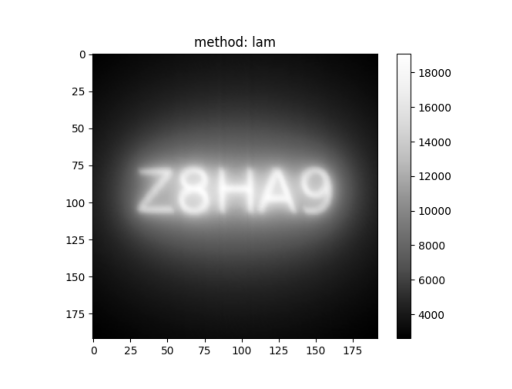

Dimension : 640 X 480 

Laminogramme obtenu du sinogram-patient:



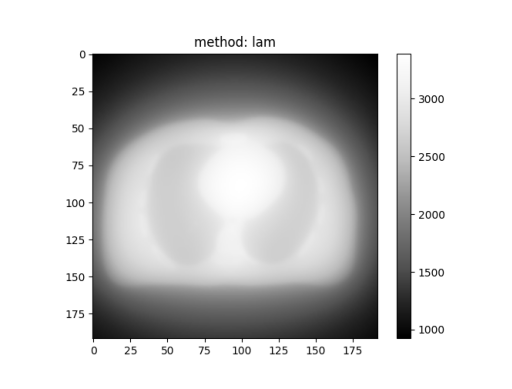

Dimension : 640 X 480 

Image du fantôme numérique:



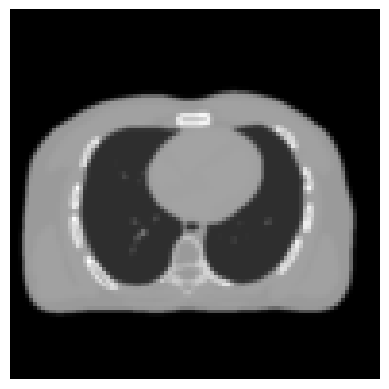

Dimension : 96 X 96 


In [5]:
#Code pour résoudre le numéro 2

print("Laminogramme obtenu du sinogram-password:\n")
image = mpimg.imread('mot_de_passe.png')
plt.imshow(image)
plt.axis('off')
plt.show()
image = Image.open('mot_de_passe.png')
width, height = image.size
print(f"Dimension : {width} X {height} \n")

print("Laminogramme obtenu du sinogram-patient:\n")
image = mpimg.imread('laminogramme.png')
plt.imshow(image)
plt.axis('off')
plt.show()
image = Image.open('laminogramme.png')
width, height = image.size
print(f"Dimension : {width} X {height} \n")


print("Image du fantôme numérique:\n")
image = mpimg.imread('phantom-thorax-096-smooth.png')
plt.imshow(image, cmap="gray")
plt.axis('off') 
plt.show()
image = Image.open('phantom-thorax-096-smooth.png')
width, height = image.size
print(f"Dimension : {width} X {height} ")


Trois différences majeures sont identifiables entre le sinogramme du patient et le fantôme numérique:

- le contraste est plus fort sur l'image du fantôme numérique que sur celle du laminogramme. Lors de la création du laminogramme, le fait d’étaler les projections sur la grille de l’image ajoute beaucoup de composantes de basse fréquence spatiale dans l’image [1]; nous nous retrouvons alors avec un contraste plus faible sur le laminogramme que sur le fantôme initiale. Cela fait en sorte que nous perdons plusieurs détails de l'image; dans ce cas-ci, nous perdons entièrement la position des os ainsi que les tâches dans les poumons, ce qui rend le laminogramme ainsi obtenu inutile d'un point de vue médical!

- l'image du fantôme numérique est plus pixelisée que celle du laminogramme. En effet, l'image du fantôme numérique a une dimension de 96x96, alors que le laminogramme obtenu est de 192x192. Ceci est simplement dû au fait que, lors de la reconstruction des voxels, nous avons utilisé une matrice 192x192 comme grille virtuelle de reconstruction; en vérité, nous ne gagnons pas d'information supplémentaire avec cette pixelisation augmentée.

- Il est également possible de constater que la MTF (Modulation Transfer Function) [4] associée à notre traitement d'image est très faible pour les hautes fréquences spatiales. En effet, nous observons que notre traitement d'image a des difficultés à rendre les hautes fréquences spatiales. Cela peut être mis en évidence en se concentrant sur la zone de transition entre le patient et le vide de l'image. Sur le fantôme, la délimitation est franche et nette, ce qui correspond à des hautes fréquences spatiales, tandis que sur l'image traitée, la transition est plus progressive, indiquant une dominance de basses fréquences spatiales. Ce phénomène suggère que le traitement a atténué les détails fins de l'image ou amplifié les basses férquences, réduisant ainsi la capacité à distinguer les transitions abruptes.


Il faut certainement améliorer l'image obtenue si l'on veut pouvoir utiliser le laminogramme à des fins médicales! C'est ce que nous ferons au numéro suivant.

# Numéro 3

Comme mentionné dans le paragraphe précédent, les hautes fréquences sont largement sous-représentées dans l'image produite par le laminogramme. Pour remédier à cela, il est possible d'effectuer un filtrage des données du sinogramme. L'application d'un filtre passe-haut permettrait de réduire l'amplitude des basses fréquences afin de mieux mettre en évidence les hautes fréquences. Ces dernières sont en effet déterminantes pour la capacité de résolution de notre traitement d'image.

Dans notre cas, le filtre passe bas sera appliqué ligne par ligne. En d'autre mots, chaque ligne du sinogramme sera filtré via une fft selon l'algorithme suivant : 

$
\begin{align}
    P(u) &= F[p(t)] \\
    P_f(u) &= P(u) \times |u| \\
    p_f(t) &= F^{-1}[P(u) \times |u|]
\end{align}
$
où $p(t)$ et $p_f(t)$ sont respectivement le signal temporel non-filtré et filtré. Aussi, $F$ représente l'opérateur de la tranformé de fourrier et $|u|$ est notre filtre passe-haut rudimentaire (une rampe).

In [6]:
## filtrer le sinogramme
## ligne par ligne
def filterSinogram(sinogram):
    for i in range(sinogram.shape[0]):
        sinogram[i] = filterLine(sinogram[i])
    return sinogram

## filter une ligne (projection) via FFT
def filterLine(projection):
    fft_proj = np.fft.fft(projection)
    fft_proj = np.fft.fftshift(fft_proj)
    
    freqs = np.fft.fftfreq(len(projection))

    # filtre en rampe
    ramp = np.abs(freqs)
    ramp = 1 - ramp/np.max(ramp)

    # appliquer le filtre
    fft_proj = fft_proj*ramp

    # retourner dans l'espace des fréquences
    fft_proj = np.fft.ifftshift(fft_proj)
    filtered_proj = np.fft.ifft(fft_proj)

    return np.real(filtered_proj)

Appliquons maintenant cet algorithm à notre sinograme.

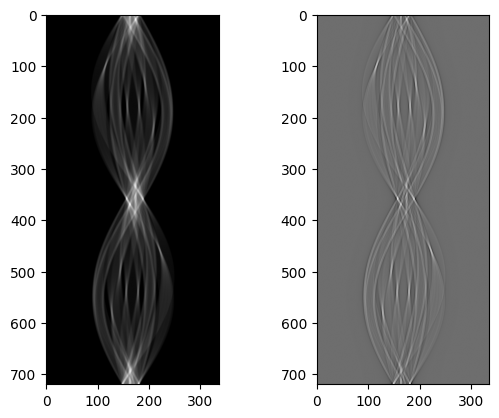

In [7]:
## visualiser le sinogramme avant et après filtrage
[_, _, sinogram] = readInput(geo.dataDir + geo.anglesFile, geo.dataDir + geo.pwSinogramFile)
plt.subplot(1, 2, 1)
plt.imshow(sinogram, cmap='gray')
sinogram = filterSinogram(sinogram)
plt.subplot(1, 2, 2)
plt.imshow(sinogram, cmap='gray')
plt.show()

Il est désormais possible de confirmer que notre algorithme filtre correctement nos données, comme prévu. En effet, une observation attentive au centre de l'image (à l'intersection) montre que les différents signaux (traits) sont plus fins et mieux définis après le filtrage. Il est ainsi plus facile de distinguer les signaux qui se croisent dans l'image filtrée que dans l'image non filtrée, où les transitions sont moins nettes. Nous pouvons maintenant présenter les observations officielles concernant notre sinogramme, tant dans sa version non filtrée que filtrée. Ces deux versions de l'image nous offrent la possibilité de comparer l'impact du filtrage sur les données et d'évaluer plus précisément les améliorations apportées par l'algorithme.

Sinogramme patient original (fourni):



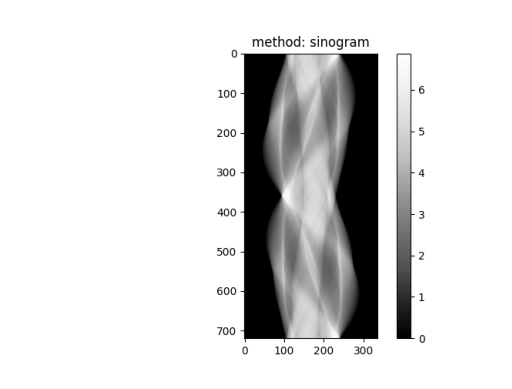

Sinogramme patient filtré passe-haut:



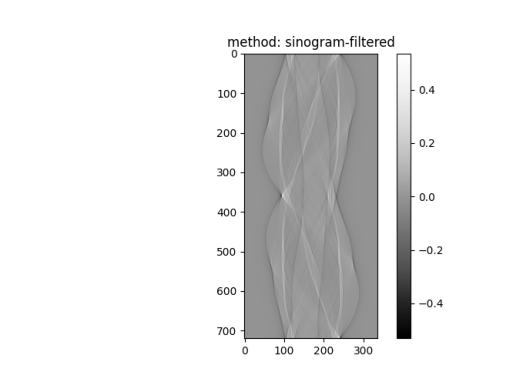

In [8]:
#Code pour résoudre le numéro 3
print("Sinogramme patient original (fourni):\n")
image = mpimg.imread('sinogram-patient.png')
plt.imshow(image)
plt.axis('off')
plt.show()

print("Sinogramme patient filtré passe-haut:\n")
image = mpimg.imread('sinogram-patient-filtered.png')
plt.imshow(image, cmap="gray")
plt.axis('off')
plt.show()

Bien qu'il soit qualitativement évident que les deux sinnogrammes proviennent du même set de données, plusieurs différences sont observées:

- Comme l'on s'y attend, seulement les haute fréquences sont conservées une fois le sinogramme filtré. Cela fait donc en sorte que nous voyons très facilement les zones de contraste (c'est sont d'ailleurs les zones qui, de manière générale, nous intéressent le plus d'un point de vue médicale), alors qu'elles sont moins évidents dans le graphique non-filtré. 

- De plus, l'on observe que l'intensité des pixels sur l'image est moindre pour le sinogramme filtré. Cela est également attendu puisqu'en filtrant les basses fréquence, nous éliminons les composantes "DC" qui rehaussent les valeurs des pixels de larges plages spatiales. 

# Numéro 4

Maintenant que nous avons filtré le sinogramme, nous pouvons reconstruire l'image du fantôme numérique. Pour ce faire, nous allons utiliser la méthode de rétroprojection filtrée. Nous allons d'abord définir la fonction de rétroprojection filtrée. Pour ce faire nous nous baserons fortement sur la méthode utilisé au 

In [9]:
def backproject(data_input: list[int, np.ndarray, np.ndarray]) -> None:
    
    [nbprj, angles, sinogram] = data_input
    
    # initialiser une image reconstruite
    image = np.zeros((geo.nbvox, geo.nbvox))
    
    ### option filtrer ###
    sinogram = filterSinogram(sinogram)
    ######
    
    # "etaler" les projections sur l'image
    # ceci sera fait de façon "voxel-driven"
    # pour chaque voxel, trouver la contribution du signal reçu
    for j in range(geo.nbvox): # colonnes de l'image
        print(f"\rWorking on image column: {str(j+1)}/{str(geo.nbvox)}", end="", flush=True)
        for i in range(geo.nbvox): # lignes de l'image
            for a in range(0, len(angles), 1):
                            
                mid_ray = geo.nbpix/2 # indice du rayon central
                mid_vox = geo.nbvox/2 # indice du voxel central en x et en y
                angle = angles[a]
                proj = sinogram[a]

                # déterminer si le rayon est dirigé vers la gauche ou la droite
                # l'algorithme est fait pour les rayons dirigés vers la gauche
                # on peut corriger à la fin pour les rayons dirigés vers la droite
                ray_dir = "left" if angle < np.pi else "right"

                # angle entre 0 et pi
                angle %= np.pi

                # position en voxels relative au centre de la grille de reconstruction
                current_vox_x = j - mid_vox
                current_vox_y = mid_vox - i

                # paramètre d'une droite passant par le voxel courant et la pente du rayon actuel
                m = np.tan(angle + np.pi/2)
                b = current_vox_y - m * current_vox_x

                # vecteur perpendiculaire à la droite mx+b et allant vers le centre de la grille
                perp_vector = [m*b/(m**2 + 1), -b/(m**2 + 1)]

                # norme et angle du vecteur perpendiculaire
                norm_to_center = np.linalg.norm(perp_vector)
                angle_to_center = np.arctan2(perp_vector[1], perp_vector[0])

                # décalage en pixels (détecteur) à partir du centre du détecteur pour avoir le rayon
                # croisant le voxel courant
                if np.isnan(angle_to_center): # si le courant est au centre de la grille, le vecteur est nul
                    ray_index = mid_ray
                
                else: # on ajuste le décalage en fonction de si le vecteur perpendiculaire
                    # pointe dans la même direction que le l'axe du détecteur ou non
                    # Si les angles sont opposés, le décalage doit être inversé 
                    # (sens contraire de t dans la figure 2 de l'énoncé)

                    n_ray_shift = norm_to_center * geo.voxsize / geo.pixsize # convertis n_voxels à n_pixels/n_rays

                    if int(angle_to_center) == int(angle):
                        factor = 1
                    else:
                        factor = -1
                    
                    if ray_dir == "right": # si le rayon est dirigé vers la droite (angle initial > pi avant le modulo)
                                        # on flip l'image dans les deux axes pour garder le même algorithme
                        i = geo.nbvox - i - 1
                        j = geo.nbvox - j - 1
                    
                    ray_index = int(mid_ray + n_ray_shift * factor)

                image[i, j] += proj[ray_index]

    util.saveImage(image, "Rétroprojection filtrée")

In [10]:
# Lire les données du fichier d'angles et de "sinogram-patient.txt"
data_input = readInput(geo.dataDir + geo.anglesFile, geo.dataDir + geo.ptSinogramFile)
# Créer le laminogram
backproject(data_input)

Working on image column: 192/192

<Figure size 640x480 with 0 Axes>

Nous pouvons remarquer que la netteté de notre image s'est grandement améliorée, avec une définition des détails beaucoup plus précise et des contours plus nets. Cette amélioration rend maintenant pertinente une comparaison approfondie entre notre nouvelle image filtrée et le fantôme, afin de mieux évaluer la précision et la fidélité des résultats obtenus par notre algorithme de traitement.

Laminogramme obtenu du sinogram-patient filtré passe-haut:



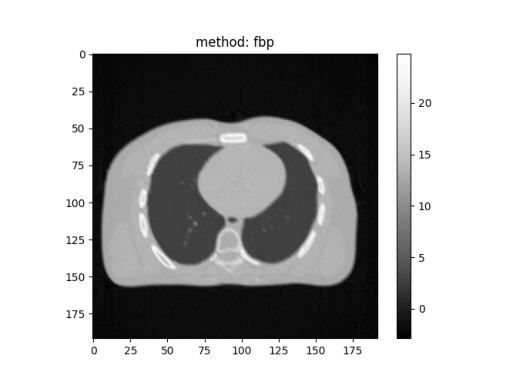

Fantôme numérique initial:



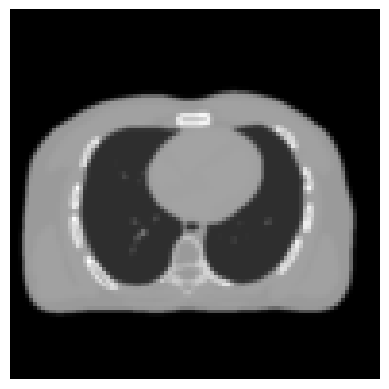

In [11]:
#Code pour résoudre le numéro 4
print("Laminogramme obtenu du sinogram-patient filtré passe-haut:\n")
image = mpimg.imread('backproject.png')
plt.imshow(image)
plt.axis('off')
plt.show()

print("Fantôme numérique initial:\n")
image = mpimg.imread('phantom-thorax-096-smooth.png')
plt.imshow(image, cmap="gray")
plt.axis('off')
plt.show()

Wow, cela fait toute une différence vs le sinogramme non-filtré! L'on remarque toutefois deux différences majeurs avec le fantôme initial:

- encore une fois, la résolution du laminogramme est supérieure à celle du fantôme numérique. Comme à la question 2, cela est dû au fait que nous représentons les voxels sur une grille 192x192, alors que le fantôme numérique est une image de taille 96x96. Il est important de préciser que, comme précédemment, nous ne gagnons pas d'informations supplémentaire avec cette résolution supérieure, bien qu'elle soit plus agréable à regarder!

- il y a quelques artéfacts dans le laminogramme produit à partir du sinogramme filtré. Ces artéfacts se produisent à une fréquence spatiale d'environ 6-8 pixels, et sont surtout visibles dans les secteurs pâles de l'image du laminogramme. Ils sont dû très certainement au filtre, qui élimine les basses fréquence, ce qui explique pourquoi nous remarquons ces erreurs à une basse fréquence spatiale. 

De manière générale, le laminogramme produit à partir du sinogramme filtré est de bien meilleure utilité pour le domaine médicale que ne l'était le laminogramme produit à partir du sinogramme non-filtré.

# Numéro 5

Tel que demandé dans l'énoncé, nous implémenterons une seconde méthode permettant d'obtenir les images en TDM. La fonction $\textit{reconFourierSlice}$ reconstruit une image à partir de projections TDM en utilisant le théorème de la tranche de Fourier. Elle applique d’abord une transformée de Fourier 1D aux projections du sinogramme, puis projette ces données dans l’espace de Fourier 2D en les positionnant selon leurs angles. Une interpolation est effectuée pour adapter ces données polaires à une grille cartésienne. Enfin, une transformée de Fourier inverse 2D est appliquée pour obtenir l’image reconstruite, qui est ensuite enregistrée.

In [12]:
from scipy.interpolate import griddata

## reconstruire une image TDM en mode retroprojection
def reconFourierSlice(data_input: list[int, np.ndarray, np.ndarray]) -> None:
    
    [nbprj, angles, sinogram] = data_input

    sinogram = np.fft.ifftshift(sinogram, axes=1)
    sinogram = np.fft.fft(sinogram, axis=1)
    sinogram = np.fft.fftshift(sinogram, axes=1)

    theta = angles
    s = sinogram.shape[1]
    r = np.arange(s) - s/2
    
    R, Theta = np.meshgrid(r, theta)
    x = R*np.cos(Theta)
    y = R*np.sin(Theta)

    x_flat = x.flatten()
    y_flat = y.flatten()
    v_flat = sinogram.flatten()

    grid_x, grid_y = np.meshgrid(
        np.arange(-geo.nbvox/2, geo.nbvox/2),
        np.arange(-geo.nbvox/2, geo.nbvox/2)
    )
    
    IMAGE = griddata(
        (x_flat, y_flat),
        v_flat,
        (grid_x, grid_y),
        method='cubic',
        fill_value=1e7,
    )

    image = np.fft.ifft2(IMAGE)
    image = np.fft.ifftshift(image)
    image = np.abs(image)

    util.saveImage(image, "Fourier slice theorem")

In [13]:
# Lire les données du fichier d'angles et de "sinogram-patient.txt"
data_input = readInput(geo.dataDir + geo.anglesFile, geo.dataDir + geo.ptSinogramFile)
# Créer le laminogram
reconFourierSlice(data_input)

<Figure size 640x480 with 0 Axes>

Laminogramme obtenu par la méthode des tranches de Fourier:



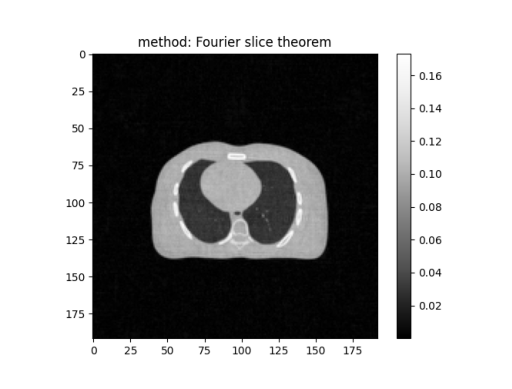

Fantôme numérique initial:



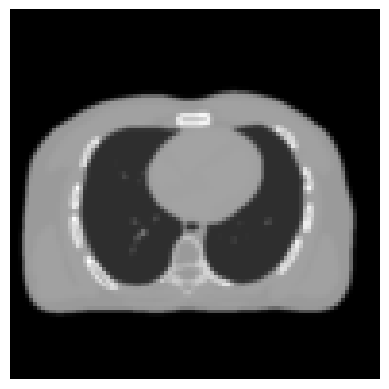

In [15]:
#Code pour résoudre le numéro 4
print("Laminogramme obtenu par la méthode des tranches de Fourier:\n")
image = mpimg.imread('Fourier slice theorem-20250322-112227.png')
plt.imshow(image)
plt.axis('off')
plt.show()

print("Fantôme numérique initial:\n")
image = mpimg.imread('phantom-thorax-096-smooth.png')
plt.imshow(image, cmap="gray")
plt.axis('off')
plt.show()

Voici l'image reconstruite par le théorème de la tranche de Fourier. Qualitativement, l'image obtenue présente une netteté similaire à celle obtenue avec la méthode de la rétroprojection filtrée. En effet, la résolution de l'image semble plutôt comparable. Cependant, il est important de mentionner que cette méthode permet d’obtenir un résultat équivalent sans avoir à filtrer les projections. De plus, le temps de calcul est nettement inférieur : 4,7 s pour cette méthode contre 5 min 25 s pour la méthode basée sur les rétroprojections. On remarque toutefois que l'image semble *dézoomée* par rapport au fantôme numérique, ce qui est inexpliqué.

# Bibliographie

[1] TP2 : Reconstruction tomographique, D. Matenine et P. Després, *PHY-3500– Physique num´erique (H25)*

[2] Pourquoi réaliser une tomodentometrie, Information hospitalière, <https://www.informationhospitaliere.com/tomodensitometrie-deroulement-precautions-et-effets-secondaires#Pourquoi_realiser_une_tomodensitometrie%E2%80%89>

[3] XCOM database, NIST, <https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html>

[4] Jerrold T. Bushberg The Essential Physics of Medical Imaging